<a href="https://colab.research.google.com/github/Aninha33/TCC/blob/main/Otimizador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [261]:
# Instalar dependência para remover acentos 💕
!pip install -q unidecode

# Gurobi 🎶
!pip install gurobipy

In [262]:
# === 😎 Imports e autenticação ===
import unidecode
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default
import re

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# === 👀 Função para ler dados do Google Sheets ===
def get_google_sheet_data(sheet_url, aba_nome):
    planilha = gc.open_by_url(sheet_url)
    aba = planilha.worksheet(aba_nome)
    dados = aba.get_all_values()
    df = pd.DataFrame(dados[1:], columns=dados[0])
    return df

# === 📡 URLs e abas ===
url_disciplinas = 'https://docs.google.com/spreadsheets/d/1wqxz3XVefI_VXWuNF4xN2MQOz4f7PQwrEyDbJCLO6bE'
url_respostas   = 'https://docs.google.com/spreadsheets/d/1W10VIGJg-w4kcDzojCpQQC4FNSMWK9-IZEhM8pRZG30/edit?usp=sharing'

aba_disciplinas = 'Cópia de 2025-1 (caso 0)'
aba_respostas   = 'Respostas dos Formulários 1'

# === 👓 Leitura das planilhas ===
df_disciplinas = get_google_sheet_data(url_disciplinas, aba_disciplinas)
df_respostas   = get_google_sheet_data(url_respostas, aba_respostas)

# === 💅 Transformação da planilha de disciplinas ===
disciplinas_long = df_disciplinas.melt(
    id_vars=['Período', 'Disciplinas Ofertadas na COENC', 'CH'],
    var_name='Nome',
    value_name='CH_Prof'
)

# === 💥 Remove linhas onde não há carga horária atribuída ===
disciplinas_long = disciplinas_long[disciplinas_long['CH_Prof'].str.strip() != '']
disciplinas_long['Nome'] = disciplinas_long['Nome'].str.strip().str.lower()

# === ⚙ Normalização dos nomes das respostas ===
def extrair_primeiro_nome(nome_completo):
    if isinstance(nome_completo, str):
        primeiro = nome_completo.strip().split()[0]
        return unidecode.unidecode(primeiro.lower())
    return ''

df_respostas['Nome'] = df_respostas['Nome Completo'].apply(extrair_primeiro_nome)

# === 💑 Merge das planilhas ===
df_completo = pd.merge(disciplinas_long, df_respostas, on='Nome', how='left')

# 🗑 Remove linhas com 'Disciplinas Ofertadas na COENC' e 'Período' vazias ou em branco
df_completo = df_completo[df_completo['Disciplinas Ofertadas na COENC'].notna() & (df_completo['Disciplinas Ofertadas na COENC'].str.strip() != '')]
df_completo = df_completo[df_completo['Período'].notna() & (df_completo['Período'].str.strip() != '')]

# 🗑 Remove a coluna 'Carimbo de data/hora' e email
df_completo = df_completo.drop(columns=['Carimbo de data/hora', 'Endereço de e-mail'])


# === 👩‍⚖️ Preferências por horário ===
dias_semana = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta']
colunas_preferencia = [f'Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de {dia}' for dia in dias_semana]
colunas_rejeicao = [f'Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na {dia}' for dia in dias_semana]
colunas_rejeicao_alt = [f'Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades presenciais no campus relacionadas a aulas na {dia}' for dia in dias_semana]

turnos = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6',
          'T1', 'T2', 'T3', 'T4', 'T5', 'T6']

linhas = []

for i, row in df_respostas.iterrows():
    nome = row['Nome'].strip()

    for i_dia, dia in enumerate(dias_semana):
        col_pref = colunas_preferencia[i_dia]
        col_rej1 = colunas_rejeicao[i_dia]
        col_rej2 = colunas_rejeicao_alt[i_dia]

        horarios_dia = {t: 0 for t in turnos}

        # Horários preferidos (+1) 🤞
        if pd.notna(row.get(col_pref)):
            horarios_pref = re.findall(r'[MTN]\d', row[col_pref])
            for h in horarios_pref:
                horarios_dia[h] = 1

        # Horários rejeitados (-1) se ainda não tiver +1 ☝
        for col_rej in [col_rej1, col_rej2]:
            if col_rej in row and pd.notna(row[col_rej]):
                horarios_rej = re.findall(r'[MTN]\d', row[col_rej])
                for h in horarios_rej:
                    if horarios_dia[h] == 0:
                        horarios_dia[h] = -1

        for turno, valor in horarios_dia.items():
            linhas.append({
                'nome': nome,
                'dia': dia,
                'horario': turno,
                'preferencia': valor
            })

preferencias_formatadas = pd.DataFrame(linhas)

# === 📅 Adicionar horários padrão para professores que não responderam ===
df_ch = disciplinas_long.pivot_table(index='Nome', columns='Período', values='CH_Prof', aggfunc='first').fillna(0)
df_ch = df_ch.applymap(lambda x: int(x) if str(x).isdigit() else 0)

professores_com_ch = df_ch[df_ch.sum(axis=1) > 0].index
professores_com_pref = preferencias_formatadas['nome'].unique()
faltando = [p for p in professores_com_ch if p not in professores_com_pref]

horarios_default = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
linhas_default = []

for nome in faltando:
    for dia in dias_semana:
        for h in horarios_default:
            linhas_default.append({
                'nome': nome,
                'dia': dia,
                'horario': h,
                'preferencia': 0
            })

preferencias_formatadas = pd.concat([
    preferencias_formatadas,
    pd.DataFrame(linhas_default)
], ignore_index=True)

print(f"✅ Horários padrão adicionados para {len(faltando)} professores que não responderam o formulário.")

# === 🎭 Preferência por aulas condensadas ou espalhadas ===
def interpretar_condensadas(valor):
    if isinstance(valor, str):
        valor = valor.strip().lower()
        if 'condensada' in valor:
            return -1
        elif 'espalhada' in valor:
            return 1
    return 0

df_respostas['pref_p'] = df_respostas['Prefere que as Aulas sejam'].apply(interpretar_condensadas)

# === 🎆 Exibir saídas ===
print("✅ DataFrame completo (disciplinas + respostas):")
display(df_completo.head())

print("\n✅ Preferências por professor, dia e horário:")
display(preferencias_formatadas.head())

print("\n✅ Parâmetro de preferência por aulas condensadas ou espalhadas:")
display(df_respostas[['Nome', 'pref_p']].head())


✅ Horários padrão adicionados para 5 professores que não responderam o formulário.
✅ DataFrame completo (disciplinas + respostas):


<ipython-input-262-46b0e93c33d3>:110: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_ch = df_ch.applymap(lambda x: int(x) if str(x).isdigit() else 0)


,Período,Disciplinas Ofertadas na COENC,CH,Nome,CH_Prof,Nome Completo,"No próximo semestre, gostaria de:","Gostaria de ministrar aulas em outros cursos, além da Engenharia de Computação?",Quais os dias que gostaria de realizar a MANUTENÇÃO de ensino (Máximo dois dias),Quantas matérias está ministrando Atualmente?,...,"Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Segunda","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Terça","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Quarta","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Quinta","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Sexta","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades presenciais no campus relacionadas a aulas na Segunda","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Terça","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Quarta","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Quinta","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Sexta"
0,1,Materiais e Equipamentos Elétricos,4,adalberto,4,Adalberto Ana Carolina Ribeiro Miranda,Manter apenas as disciplinas que ministro aulas,Não,"Segunda, Terça",4,...,M5 (11h10 - 12h),,"M5 (11h10 - 12h), T4 (15h50 - 16h40), T5 (16h4...","T3 (14h40 - 15h30), T4 (15h50 - 16h40), T5 (1...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","2 M1 (7h30 - 8h20), 2 M2 (8h20 - 9h10) ., 2 M3...",3 M1 (7h30 - 8h20),,"5 M1 (7h30 - 8h20), 5 M2 (8h20 - 9h10)",6 M1 (7h30 - 8h20)
1,7,Controle Digital,4,adalberto,4,Adalberto Ana Carolina Ribeiro Miranda,Manter apenas as disciplinas que ministro aulas,Não,"Segunda, Terça",4,...,M5 (11h10 - 12h),,"M5 (11h10 - 12h), T4 (15h50 - 16h40), T5 (16h4...","T3 (14h40 - 15h30), T4 (15h50 - 16h40), T5 (1...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","2 M1 (7h30 - 8h20), 2 M2 (8h20 - 9h10) ., 2 M3...",3 M1 (7h30 - 8h20),,"5 M1 (7h30 - 8h20), 5 M2 (8h20 - 9h10)",6 M1 (7h30 - 8h20)
4,3,Arquitetura e Organização de Computadores,6,andre,6,"André ""Meremere"" Paysandu",Trocar as matérias,Sim,"Terça, Quinta",4,...,"M5 (11h10 - 12h), M6 (12h - 12h50), T1 (13h - ...","M4 (10h20 - 11h10), M5 (11h10 - 12h), M6 (12h ...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","T1 (13h - 13h50), T2 (13h50 - 14h40), T3 (14h...","M4 (10h20 - 11h10), M5 (11h10 - 12h), M6 (12h ...","2 M1 (7h30 - 8h20), 2 M2 (8h20 - 9h10)",,,"5 M1 (7h30 - 8h20), 5 M2 (8h20 - 9h10), 5 M3 (...","6 M1 (7h30 - 8h20), 6 M2 (8h20 - 9h10)"
5,5,Sistemas Operacionais,4,andre,4,"André ""Meremere"" Paysandu",Trocar as matérias,Sim,"Terça, Quinta",4,...,"M5 (11h10 - 12h), M6 (12h - 12h50), T1 (13h - ...","M4 (10h20 - 11h10), M5 (11h10 - 12h), M6 (12h ...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","T1 (13h - 13h50), T2 (13h50 - 14h40), T3 (14h...","M4 (10h20 - 11h10), M5 (11h10 - 12h), M6 (12h ...","2 M1 (7h30 - 8h20), 2 M2 (8h20 - 9h10)",,,"5 M1 (7h30 - 8h20), 5 M2 (8h20 - 9h10), 5 M3 (...","6 M1 (7h30 - 8h20), 6 M2 (8h20 - 9h10)"
8,6,Processamento Digital de Sinais,4,daniel,4,Daniel Thiago Berto Minson,Manter as matérias e ministrar outras,Sim,"Segunda, Sexta",7,...,"M1 (7h30 - 8h20), M2 (8h20 - 9h10), M3 (9h10 -...","M1 (7h30 - 8h20), M2 (8h20 - 9h10), M3 (9h10 -...","M1 (7h30 - 8h20), M2 (8h20 - 9h10), M3 (9h10 -...","M1 (7h30 - 8h20), M2 (8h20 - 9h10), M3 (9h10 -...",,"2 T1 (13h - 13h50), 2 T2 (13h50 - 14h40), 2 T3...","3 T1 (13h - 13h50), 3 T2 (13h50 - 14h40), 3 T3...",,,"6 T2 (13h50 - 14h40), 6 T3 (14h40 - 15h30), 6..."



✅ Preferências por professor, dia e horário:


,nome,dia,horario,preferencia
0,adalberto,Segunda,M1,-1
1,adalberto,Segunda,M2,-1
2,adalberto,Segunda,M3,-1
3,adalberto,Segunda,M4,0
4,adalberto,Segunda,M5,1



✅ Parâmetro de preferência por aulas condensadas ou espalhadas:


,Nome,pref_p
0,adalberto,-1
1,daniel,1
2,fabio,-1
3,andre,-1
4,fernando,1


-------------
SOOCOROROOROOO DEUX


In [263]:
# === 🎆 Exibir saída completa ===

print("✅ DataFrame completo (disciplinas + respostas):")
display(df_completo)

✅ DataFrame completo (disciplinas + respostas):


,Período,Disciplinas Ofertadas na COENC,CH,Nome,CH_Prof,Nome Completo,"No próximo semestre, gostaria de:","Gostaria de ministrar aulas em outros cursos, além da Engenharia de Computação?",Quais os dias que gostaria de realizar a MANUTENÇÃO de ensino (Máximo dois dias),Quantas matérias está ministrando Atualmente?,...,"Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Segunda","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Terça","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Quarta","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Quinta","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Sexta","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades presenciais no campus relacionadas a aulas na Segunda","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Terça","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Quarta","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Quinta","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Sexta"
0,1,Materiais e Equipamentos Elétricos,4,adalberto,4,Adalberto Ana Carolina Ribeiro Miranda,Manter apenas as disciplinas que ministro aulas,Não,"Segunda, Terça",4,...,M5 (11h10 - 12h),,"M5 (11h10 - 12h), T4 (15h50 - 16h40), T5 (16h4...","T3 (14h40 - 15h30), T4 (15h50 - 16h40), T5 (1...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","2 M1 (7h30 - 8h20), 2 M2 (8h20 - 9h10) ., 2 M3...",3 M1 (7h30 - 8h20),,"5 M1 (7h30 - 8h20), 5 M2 (8h20 - 9h10)",6 M1 (7h30 - 8h20)
1,7,Controle Digital,4,adalberto,4,Adalberto Ana Carolina Ribeiro Miranda,Manter apenas as disciplinas que ministro aulas,Não,"Segunda, Terça",4,...,M5 (11h10 - 12h),,"M5 (11h10 - 12h), T4 (15h50 - 16h40), T5 (16h4...","T3 (14h40 - 15h30), T4 (15h50 - 16h40), T5 (1...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","2 M1 (7h30 - 8h20), 2 M2 (8h20 - 9h10) ., 2 M3...",3 M1 (7h30 - 8h20),,"5 M1 (7h30 - 8h20), 5 M2 (8h20 - 9h10)",6 M1 (7h30 - 8h20)
4,3,Arquitetura e Organização de Computadores,6,andre,6,"André ""Meremere"" Paysandu",Trocar as matérias,Sim,"Terça, Quinta",4,...,"M5 (11h10 - 12h), M6 (12h - 12h50), T1 (13h - ...","M4 (10h20 - 11h10), M5 (11h10 - 12h), M6 (12h ...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","T1 (13h - 13h50), T2 (13h50 - 14h40), T3 (14h...","M4 (10h20 - 11h10), M5 (11h10 - 12h), M6 (12h ...","2 M1 (7h30 - 8h20), 2 M2 (8h20 - 9h10)",,,"5 M1 (7h30 - 8h20), 5 M2 (8h20 - 9h10), 5 M3 (...","6 M1 (7h30 - 8h20), 6 M2 (8h20 - 9h10)"
5,5,Sistemas Operacionais,4,andre,4,"André ""Meremere"" Paysandu",Trocar as matérias,Sim,"Terça, Quinta",4,...,"M5 (11h10 - 12h), M6 (12h - 12h50), T1 (13h - ...","M4 (10h20 - 11h10), M5 (11h10 - 12h), M6 (12h ...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","T1 (13h - 13h50), T2 (13h50 - 14h40), T3 (14h...","M4 (10h20 - 11h10), M5 (11h10 - 12h), M6 (12h ...","2 M1 (7h30 - 8h20), 2 M2 (8h20 - 9h10)",,,"5 M1 (7h30 - 8h20), 5 M2 (8h20 - 9h10), 5 M3 (...","6 M1 (7h30 - 8h20), 6 M2 (8h20 - 9h10)"
8,6,Processamento Digital de Sinais,4,daniel,4,Daniel Thiago Berto Minson,Manter as matérias e ministrar outras,Sim,"Segunda, Sexta",7,...,"M1 (7h30 - 8h20), M2 (8h20 - 9h10), M3 (9h10 -...","M1 (7h30 - 8h20), M2 (8h20 - 9h10), M3 (9h10 -...","M1 (7h30 - 8h20), M2 (8h20 - 9h10), M3 (9h10 -...","M1 (7h30 - 8h20), M2 (8h20 - 9h10), M3 (9h10 -...",,"2 T1 (13h - 13h50), 2 T2 (13h50 - 14h40), 2 T3...","3 T1 (13h - 13h50), 3 T2 (13h50 - 14h40), 3 T3...",,,"6 T2 (13h50 - 14h40), 6 T3 (14h40 - 15h30), 6..."
9,8,Instrumentação Eletrônica,2,daniel,2,Daniel Thiago Berto Minson,

In [264]:
# === 🏀 Pivot direto das preferências ===
estrutura_otimizador = preferencias_formatadas.pivot_table(
    index=['nome', 'dia'],
    columns='horario',
    values='preferencia',
    fill_value=0
).reset_index()

# === 🎆 Exibir resultado ===
estrutura_otimizador

horario,nome,dia,M1,M2,M3,M4,M5,M6,T1,T2,T3,T4,T5,T6
0,adalberto,Quarta,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,adalberto,Quinta,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,adalberto,Segunda,-1.0,-1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,adalberto,Sexta,-1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,adalberto,Terça,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,wendel,Quarta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,wendel,Quinta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67,wendel,Segunda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,wendel,Sexta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [265]:
# === 🙈 Estrutura otimizada para entrada do otimizador ===

# === 👩‍🏫 Professores ===
professores_lista = sorted(estrutura_otimizador['nome'].unique())
professor_idx = {nome: idx for idx, nome in enumerate(professores_lista)}
P = len(professores_lista)

# === 📅 Dias ===
dia_idx = {dia: idx for idx, dia in enumerate(dias_semana)}
D = len(dia_idx)

# === ⏰ Horários ===
horario_idx = {hor: idx for idx, hor in enumerate(turnos)}
H = len(horario_idx)

# === 🧶 Disciplinas ===
disciplinas_lista = sorted(df_completo['Disciplinas Ofertadas na COENC'].unique())
disciplina_idx = {disc: idx for idx, disc in enumerate(disciplinas_lista)}
T = len(disciplinas_lista)


# === ✨Arrumar o Período com a Disciplina ===
periodo_disciplina = {}
for _, row in df_completo.iterrows():
    if pd.notna(row['Período']) and row['Disciplinas Ofertadas na COENC'] not in periodo_disciplina:
        periodo_disciplina[row['Disciplinas Ofertadas na COENC']] = int(row['Período'])


# TESTE Mapeiamento do nome da disciplina para o período real
# periodo_disciplina = df_completo.drop_duplicates(subset='Disciplinas Ofertadas na COENC')\
#     .set_index('Disciplinas Ofertadas na COENC')['Período'].dropna().astype(int).to_dict()  #Seleciona o Período, remove valores vazios, converte para inteiro e transforma em dicionári

# == 🐾 Arruma o índice da disciplina para o período real ==
periodo_real = {}
for nome, idx in disciplina_idx.items():
    periodo_real[idx] = periodo_disciplina.get(nome, -1)

# meio alternativo: periodo_por_disciplina = {disciplina_idx[nome]: periodo_disciplina.get(nome, -1) for nome in disciplinas_lista}


# === 🧮 Conjuntos ===
professores = range(P)
periodos = range(T)
dias = range(D)
horarios = range(H)

# === 🎀 Inicializa PV e Disp ===
PV = {}
Disp = [[[1 for _ in horario_idx] for _ in dia_idx] for _ in professor_idx]

for _, row in estrutura_otimizador.iterrows():
    p = professor_idx[row['nome']]
    d = dia_idx[row['dia']]
    for horario in turnos:
        h = horario_idx[horario]
        valor = row[horario]
        PV[(p, d, h)] = valor
        if valor == -1:
            Disp[p][d][h] = 0

# === 🎨 Criar diretamente CH e pref_p ===
CH = [[0 for _ in disciplina_idx] for _ in professor_idx]
pref_p = {professor_idx[row['Nome']]: row['pref_p'] for _, row in df_respostas.iterrows() if row['Nome'] in professor_idx}

for _, row in df_completo.iterrows():
    nome = row['Nome']
    if nome in professor_idx and row['Disciplinas Ofertadas na COENC'] in disciplina_idx:
        p = professor_idx[nome]
        t = disciplina_idx[row['Disciplinas Ofertadas na COENC']]
        ch_prof = row['CH_Prof']
        if str(ch_prof).replace(',', '').isdigit():
            CH[p][t] = int(float(ch_prof.replace(',', '.')))

# === 🎆 Exibir verificação rápida ===
print("✅ Estruturas finais geradas com sucesso!")
print("Professores (índices):", professor_idx)
print("Disciplinas (índices):", disciplina_idx)

# === 👽 Exemplo de verificação de PV e DISP de TODOS os professores ===
print("\n✅ Preferências e Disponibilidades por Professor:")
for nome_prof, idx_prof in professor_idx.items():
    print(f"\n\n👤 Professor: {nome_prof.title()}")
    for dia_nome, idx_dia in dia_idx.items():
        preferencias_dia = []
        disponibilidade_dia = []
        for turno_nome, idx_turno in horario_idx.items():
            valor_pref = PV.get((idx_prof, idx_dia, idx_turno))
            valor_disp = Disp[idx_prof][idx_dia][idx_turno]

            if valor_pref == 1:
                preferencias_dia.append(turno_nome)
            if valor_disp == 0:
                disponibilidade_dia.append(turno_nome)

        print(f"  📅 {dia_nome}:")
        print(f"    ✔️ Preferências: {preferencias_dia if preferencias_dia else 'Nenhuma'}")
        print(f"    ❌ Indisponível: {disponibilidade_dia if disponibilidade_dia else 'Nenhuma'}")


✅ Estruturas finais geradas com sucesso!
Professores (índices): {'adalberto': 0, 'andre': 1, 'daniel': 2, 'fabio': 3, 'fernando': 4, 'lucio': 5, 'luiz': 6, 'marcelo': 7, 'mauricio': 8, 'muriel': 9, 'rafael': 10, 'tamara': 11, 'wagner': 12, 'wendel': 13}
Disciplinas (índices): {'Arquitetura e Organização de Computadores': 0, 'Banco de Dados': 1, 'Compiladores': 2, 'Comunicação de Dados': 3, 'Controle Digital': 4, 'Desenho Técnico': 5, 'Desenvolvimento de Aplicações Web': 6, 'Engenharia de Software': 7, 'Estrutura de Dados 1': 8, 'Estrutura de Dados 2': 9, 'Fundamentos de Controle': 10, 'Fundamentos de Programação 1': 11, 'Fundamentos de Programação 2': 12, 'Instrumentação Eletrônica': 13, 'Introdução à Engenharia de Computação': 14, 'Introdução à Lógica para Computação': 15, 'Lógica Reconfigurável': 16, 'Materiais e Equipamentos Elétricos': 17, 'Oficina de Integração 1': 18, 'Oficina de Integração 2': 19, 'Optativa 1': 20, 'Optativa 2': 21, 'Optativa 3': 22, 'Processamento Digital de Si

In [266]:
print("Verificando índice t | disciplina → período real:")
for t in periodos:
    print(f"Índice t: {t} | Disciplina: {disciplinas_lista[t]} → Período Real: {periodo_real[t]}")


Verificando índice t | disciplina → período real:
Índice t: 0 | Disciplina: Arquitetura e Organização de Computadores → Período Real: 3
Índice t: 1 | Disciplina: Banco de Dados → Período Real: 4
Índice t: 2 | Disciplina: Compiladores → Período Real: 6
Índice t: 3 | Disciplina: Comunicação de Dados → Período Real: 5
Índice t: 4 | Disciplina: Controle Digital → Período Real: 7
Índice t: 5 | Disciplina: Desenho Técnico → Período Real: 1
Índice t: 6 | Disciplina: Desenvolvimento de Aplicações Web → Período Real: 8
Índice t: 7 | Disciplina: Engenharia de Software → Período Real: 6
Índice t: 8 | Disciplina: Estrutura de Dados 1 → Período Real: 3
Índice t: 9 | Disciplina: Estrutura de Dados 2 → Período Real: 4
Índice t: 10 | Disciplina: Fundamentos de Controle → Período Real: 6
Índice t: 11 | Disciplina: Fundamentos de Programação 1 → Período Real: 1
Índice t: 12 | Disciplina: Fundamentos de Programação 2 → Período Real: 2
Índice t: 13 | Disciplina: Instrumentação Eletrônica → Período Real: 8

In [267]:
import gurobipy as gp
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd
from oauth2client.client import GoogleCredentials

In [268]:
'''
!pip install gurobipy>=10

model_size_limited = gp.Model()
'''
from gurobipy import Env

In [269]:
# Create an environment with your WLS license
param = {
  "WLSACCESSID": 'e9019a7c-1658-49e2-89a5-f8d0ebf9d803',
  "WLSSECRET": 'a5c88295-6dd6-406e-8b53-5294263ae92b',
  "LICENSEID": 2541920
  }
env = gp.Env(params=param)

# Create the model within the Gurobi environment
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2541920
Academic license 2541920 - for non-commercial use only - registered to an___@alunos.utfpr.edu.br


In [270]:
# === Definir limite de tempo ===
model.setParam("TimeLimit", 40)

Set parameter TimeLimit to value 40


In [271]:
# === Variáveis de decisão ===
x = model.addVars(professores, periodos, dias, horarios, vtype=gp.GRB.BINARY)
b = model.addVars(professores, periodos, dias,  vtype=gp.GRB.BINARY)
e = model.addVars(professores, periodos, dias, vtype=gp.GRB.CONTINUOUS, lb=0)
f = model.addVars(professores, periodos, dias, vtype=gp.GRB.CONTINUOUS, lb=0)
a = model.addVars(professores, dias,  vtype=gp.GRB.BINARY)

In [272]:
# 💀⚠️⚠️ TESTEEEEEEEEEEE⚠️⚠️💀
# === Inicializa "Hist" como 0 para cada professor ===
Hist = {(p, t): 0 for p in professores for t in periodos}

# === O dicionário "Hist" atualizado ===
print("Hist atualizado:", Hist)


# === Remover valores inválidos de Hist ===
for k in list(Hist.keys()):
    if pd.isna(Hist[k]) or Hist[k] is None:
        Hist[k] = 0


# === Garantir que todos os valores de pref_p são numéricos e não nulos ===
for k in list(pref_p.keys()):
    if pd.isna(pref_p[k]) or pref_p[k] is None:
        pref_p[k] = 0

# === Garantir que todos os valores de PV são numéricos e não nulos ===
for k in list(PV.keys()):
    if pd.isna(PV[k]) or PV[k] is None:
        PV[k] = 0



Hist atualizado: {(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 0, (0, 7): 0, (0, 8): 0, (0, 9): 0, (0, 10): 0, (0, 11): 0, (0, 12): 0, (0, 13): 0, (0, 14): 0, (0, 15): 0, (0, 16): 0, (0, 17): 0, (0, 18): 0, (0, 19): 0, (0, 20): 0, (0, 21): 0, (0, 22): 0, (0, 23): 0, (0, 24): 0, (0, 25): 0, (0, 26): 0, (0, 27): 0, (0, 28): 0, (0, 29): 0, (0, 30): 0, (0, 31): 0, (0, 32): 0, (0, 33): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0, (1, 4): 0, (1, 5): 0, (1, 6): 0, (1, 7): 0, (1, 8): 0, (1, 9): 0, (1, 10): 0, (1, 11): 0, (1, 12): 0, (1, 13): 0, (1, 14): 0, (1, 15): 0, (1, 16): 0, (1, 17): 0, (1, 18): 0, (1, 19): 0, (1, 20): 0, (1, 21): 0, (1, 22): 0, (1, 23): 0, (1, 24): 0, (1, 25): 0, (1, 26): 0, (1, 27): 0, (1, 28): 0, (1, 29): 0, (1, 30): 0, (1, 31): 0, (1, 32): 0, (1, 33): 0, (2, 0): 0, (2, 1): 0, (2, 2): 0, (2, 3): 0, (2, 4): 0, (2, 5): 0, (2, 6): 0, (2, 7): 0, (2, 8): 0, (2, 9): 0, (2, 10): 0, (2, 11): 0, (2, 12): 0, (2, 13): 0, (2, 14): 0, (2, 15): 0, (2, 

In [273]:
# === 👻 Verificação de consistência nas chaves utilizadas ===
erros = 0
for p in professores:
    for t in periodos:
        for d in dias:
            for h in horarios:
                try:
                    _ = x[p, t, d, h]                     # variável de decisão existe
                    _ = PV.get((p, d, h), 0)              # preferência horário
                    _ = Hist.get((p, t), 0)               # histórico
                except Exception as e:
                    print(f"Erro em p={p}, t={t}, d={d}, h={h} → {e}")
                    erros += 1


# === 🚧 Teste para verificar se todas as chaves acessadas existem ===
print(f"Total de inconsistências detectadas: {erros}")


Total de inconsistências detectadas: 0


In [274]:

model.setObjective(
    gp.quicksum(PV.get((p, d, h), 0) * x[p, t, d, h] for p in professores for t in periodos for d in dias for h in horarios)
  - gp.quicksum(b[p, t, d] for p in professores for t in periodos for d in dias)
  + gp.quicksum(pref_p.get(p, 0) * a[p, d] for p in professores for d in dias)
  - gp.quicksum(Hist.get((p, t), 0) * x[p, t, d, h] for p in professores for t in periodos for d in dias for h in horarios)

  # Penalidade para períodos ímpares à tarde e pares pela manhã
  - gp.quicksum(
      (10  if (periodo_real[t] % 2 == 1 and h >= 6) else 0) * x[p, t, d, h] +
      (10  if (periodo_real[t] % 2 == 0 and h < 6) else 0) * x[p, t, d, h]
      for p in professores for t in periodos for d in dias for h in horarios ),
  sense=gp.GRB.MAXIMIZE
)


# Restrição: Cada período não pode ter aulas misturadas entre manhã e tarde no mesmo dia
for periodo in set(periodo_real.values()):
    if periodo != 10 and periodo != 11:
        disciplinas_periodo = [t for t in periodos if periodo_real[t] == periodo]
        for d in dias:
            # Não pode misturar manhã e tarde
            model.addConstr(
                gp.quicksum(x[p, t, d, h] for p in professores for t in disciplinas_periodo for h in range(0,6)) *
                gp.quicksum(x[p, t, d, h] for p in professores for t in disciplinas_periodo for h in range(6,H))
                == 0 )


---------------------
- A partir de agora é o antigo código

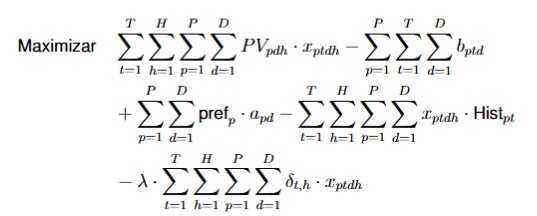

In [275]:

# impar = peso negativo - para ajudar na maximização -(5) # peso negativo para o periodo par a tarde
# par = negativo para ser negativo para virar positivo. ex = -(-5)
# Descartar lambida = substi pelo delta

# penalidade positiva = priorizar mais = priorizar o turno da manhã, por isso deve ser negativo

# Período ímpar: penalidade precisa ficar positiva no período da manhã (pq aulas preferencialmente nesse período)


# # === Variável de penalidade para horários fora da paridade do período ===
# penalidade_paridade = model.addVars(T, D, H, vtype=gp.GRB.BINARY, name="penalidade_paridade")

# for t in periodos:
#     if periodo_real[t] != 10 and periodo_real[t] != 11:
#         for d in dias:
#             for h in horarios:
#                 if (periodo_real[t] % 2 == 0 and h < 6) or (periodo_real[t] % 2 != 0 and h >= 6):  # par = tarde | ímpar = manhã
#                     for p in professores:
#                         model.addConstr(penalidade_paridade[t, d, h] >= x[p, t, d, h])

# # # Peso da penalização por violar a regra de período
# peso = 5

# # === Função objetivo ===
# model.setObjective(
#     gp.quicksum(PV.get((p, d, h), 0) * x[p, t, d, h] for p in professores for t in periodos for d in dias for h in horarios)
#   - gp.quicksum(b[p, t, d] for p in professores for t in periodos for d in dias)
#   + gp.quicksum(pref_p.get(p, 0) * a[p, d] for p in professores for d in dias)
#   - gp.quicksum(Hist.get((p, t), 0) * x[p, t, d, h] for p in professores for t in periodos for d in dias for h in horarios) # Penalidade para horários alocados
#   - gp.quicksum(penalidade_paridade[t, d, h] for t in periodos for d in dias for h in horarios), # Penalidade para Períodos Impares e Pares
#     sense=gp.GRB.MAXIMIZE)


In [276]:
# === Restrição que garante aulas consecutivas ===
for p in professores:
    for t in periodos:
      for d in dias:
            model.addConstr(gp.quicksum(x[p, t, d, h] for h in horarios) <= 100 * b[p, t, d])


In [277]:
# === Restrição para o início e fim das aulas ===
for p in professores:
    for t in periodos:
        for d in dias:
            for h in horarios:
                model.addConstr(e[p, t, d] <= (H + 1) - ((H + 1 - h) * x[p, t, d, h]))  # Início da aula
                model.addConstr(f[p, t, d] >= h * x[p, t, d, h])  # Fim da aula

for p in professores:
    for d in dias:
        for t in periodos:
            model.addConstr((f[p, t, d] - e[p, t, d] + b[p, t, d] - gp.quicksum(x[p, t, d, h] for h in horarios)) <= 0)

In [278]:
# === Restrição para alocar as aulas corretamente quando a carga horária é maior ou igual a 4 aulas ===
for p in professores:
    for t in periodos:
      if periodo_real[t] != 10 and periodo_real[t] != 11:  # exceções
        for d in dias:
            if CH[p][t] != 4 and CH[p][t] != 6:
                # model.addConstr(f[p, t, d] - e[p, t, d] <= 3 * b[p, t, d])
                model.addConstr(gp.quicksum(x[p, t, d, h] for h in horarios) <= 3 * b[p, t, d])
            else:
                # model.addConstr(f[p, t, d] - e[p, t, d] <= 2 * b[p, t, d])
                model.addConstr(gp.quicksum(x[p, t, d, h] for h in horarios) <= 2 * b[p, t, d])



# # Garante que uma disciplina não ocupe mais de 3 horários em um mesmo dia se a CH semanal for superior a 3
# for p in professores:
#     for t in periodos:
#         if sum(CH[p][t] for p in professores) > 3:  # se a disciplina tem mais de 3 aulas semanais
#             for d in dias:
#                 model.addConstr(gp.quicksum(x[p, t, d, h] for h in horarios) <= 3)


In [279]:
# === Distribuição da carga horária ===
for p in professores:
    for t in periodos:
        model.addConstr(gp.quicksum(x[p, t, d, h] for d in dias for h in horarios) == CH[p][t])



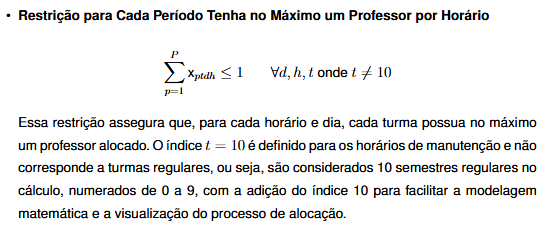

In [280]:
# === Restrição: Cada período tem que ter no dia e horário no máximo um professor alocado, exceto para turma 10 e 11 ===
# for t in periodos:
#     for d in dias:
#         for h in horarios:
#           # if t != 11 and t != 10:
#           if periodo_real[t]  != 10 and periodo_real[t]  != 11:  # exceções
#             model.addConstr(gp.quicksum(x[p, t, d, h] for p in professores) <= 1)


# === Forma alternativa -  Restrição: Cada período tem que ter no dia e horário no máximo um professor alocado, exceto para turma 10 e 11 ===
for t in periodos:
    if periodo_real[t] != 10 and periodo_real[t] != 11:
        disciplinas_mesmo_periodo = [t2 for t2 in periodos if periodo_real[t2] == periodo_real[t]]
        for d in dias:
            for h in horarios:
                model.addConstr( gp.quicksum(x[p, t2, d, h] for p in professores for t2 in disciplinas_mesmo_periodo) <= 1 )



In [281]:
# === Cada professor deve ter no máximo uma aula por horário em cada dia ===
for p in professores:
    for d in dias:
        for h in horarios:
          model.addConstr(gp.quicksum(x[p, t, d, h] for t in periodos) <= 1)

In [282]:
# 💀⚠️⚠️ TESTEEEEEEEEEEE⚠️⚠️💀
# Verificação rápida de disponibilidade por professor (apenas rodar para conferir):
for nome_prof, idx_prof in professor_idx.items():
    print(f"\nProfessor {nome_prof}:")
    for dia_nome, idx_dia in dia_idx.items():
        indisponiveis = [turnos[h] for h in horarios if Disp[idx_prof][idx_dia][h] == 0]
        print(f"  Dia {dia_nome}: Indisponível {indisponiveis}")



Professor adalberto:
  Dia Segunda: Indisponível ['M1', 'M2', 'M3']
  Dia Terça: Indisponível ['M1']
  Dia Quarta: Indisponível []
  Dia Quinta: Indisponível ['M1', 'M2']
  Dia Sexta: Indisponível ['M1']

Professor andre:
  Dia Segunda: Indisponível ['M1', 'M2']
  Dia Terça: Indisponível []
  Dia Quarta: Indisponível []
  Dia Quinta: Indisponível ['M1', 'M2', 'M3']
  Dia Sexta: Indisponível ['M1', 'M2']

Professor daniel:
  Dia Segunda: Indisponível ['T1', 'T2', 'T3', 'T4', 'T5', 'T6']
  Dia Terça: Indisponível ['T1', 'T2', 'T3', 'T4', 'T5', 'T6']
  Dia Quarta: Indisponível []
  Dia Quinta: Indisponível []
  Dia Sexta: Indisponível ['T2', 'T3', 'T4', 'T5', 'T6']

Professor fabio:
  Dia Segunda: Indisponível ['T1', 'T2']
  Dia Terça: Indisponível ['T1', 'T2', 'T3', 'T4', 'T5', 'T6']
  Dia Quarta: Indisponível []
  Dia Quinta: Indisponível ['M6', 'T5']
  Dia Sexta: Indisponível []

Professor fernando:
  Dia Segunda: Indisponível ['M2', 'M6', 'T1', 'T5']
  Dia Terça: Indisponível ['M1', 

In [283]:
# === Restrição de Preferência de Aula dos Professores ===
for p in professores:
     for d in dias:
         model.addConstr(gp.quicksum(b[p, t, d] for t in periodos) <= H * a[p,d])

In [284]:
# === Restrição de número máximo de aulas por dia para cada professor ===
for p in professores:
    for d in dias:
        model.addConstr(gp.quicksum(x[p, t, d, h] for t in periodos for h in horarios if periodo_real[t] != 10 and periodo_real[t] != 11) <= 7)

# PROBLEMA DAS AULAS SEGUIIIDAAAAAS
# for p in professores:
#     for d in dias:
#         for t in periodos:
#           if periodo_real[t] != 10 and periodo_real[t] != 11:
#               model.addConstr(gp.quicksum(x[p, t, d, h]  for h in horarios) <= 3)


# === Disponibilidade de professores ===
for p in professores:
    for d in dias:
        for h in horarios:
            model.addConstr(gp.quicksum(x[p, t, d, h] for t in periodos) <= Disp[p][d][h])

# === Preferências de aulas condensadas ou espalhadas dos professores ===
for p in professores:
    for d in dias:
        model.addConstr(gp.quicksum(b[p, t, d] for t in periodos) <= H * a[p, d])  # Condensação de aulas

In [285]:
# para CH alta (4 ou 6), bloqueio mínimo de 2h/dia
for p in professores:
    for t in periodos:
        if CH[p][t] in (4,6):
            for d in dias:
                # força: ou são 0h no dia, ou exatas 2h contíguas
                model.addConstr(
                    gp.quicksum(x[p, t, d, h] for h in horarios)
                    >= 2 * b[p, t, d]
                )


In [286]:
# 💀⚠️⚠️ TESTEEEEEEEEEEE⚠️⚠️💀

# Verificar inconsistências entre CH e disponibilidade
for p in professores:
    total_disp = sum(Disp[p][d][h] for d in dias for h in horarios)
    total_ch = sum(CH[p][t] for t in periodos)

    if total_ch > total_disp:
        print(f"⚠️ Professor {p} tem CH={total_ch}, mas só {total_disp} horários disponíveis!")


In [287]:
# 💀⚠️⚠️ TESTEEEEEEEEEEE ⚠️⚠️💀

df_ch = pd.DataFrame(CH)
df_ch.columns = [f"t{t}" for t in periodos]
df_ch.index = [f"p{p}" for p in professores]
display(df_ch)


,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t24,t25,t26,t27,t28,t29,t30,t31,t32,t33
p0,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
p1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0
p2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
p3,0,0,0,0,0,4,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
p4,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,0
p5,0,0,0,0,0,0,0,0,0,0,...,4,0,0,4,0,0,0,0,0,0
p6,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
p7,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,0,0
p8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0
p9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [288]:
# === 💛 Resolver o modelo 💛  ===
model.optimize()
status = model.status

# === Verificando o status da solução ===
if status == gp.GRB.Status.OPTIMAL or status == gp.GRB.TIME_LIMIT:
    print("Otimização bem-sucedida!")
    alocacoes = {}

    for p in range(0, P):
        for t in range(0, T):
            for d in range(0, D):
                horarios = []
                for h in range(0, H):
                    if x[p, t, d, h].X > 0.7:
                        horarios.append(h)
                if horarios:
                    if p not in alocacoes:
                        alocacoes[p] = {}
                    if d not in alocacoes[p]:
                        alocacoes[p][d] = []
                    alocacoes[p][d].append((t, horarios))

    # === 🥰 Exibir as alocações agrupadas por professor e dia ===
    for p, dias in alocacoes.items():
        print(f"\n👩‍🏫Professor {professores_lista[p]}: 👨‍🏫")
        for d, periodos in dias.items():
            print(f"  📅 {dias_semana[d]}:")
            for t, horarios in periodos:
                periodo_lista = periodo_disciplina.get(disciplinas_lista[t], "???")
                print(f"    ⏰Período {periodo_lista} ({disciplinas_lista[t]}): Horários {', '.join([turnos[h] for h in horarios])}")


else:
    print(f"Otimização não foi bem-sucedida. Status: {status}")

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  40

Academic license 2541920 - for non-commercial use only - registered to an___@alunos.utfpr.edu.br
Optimize a model with 68796 rows, 35770 columns and 456270 nonzeros
Model fingerprint: 0x8c76f0d1
Model has 45 quadratic constraints
Variable types: 4760 continuous, 31010 integer (31010 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 41721 rows and 33477 columns
Presolve time: 1.33s
Presolved: 27075 rows, 2293 columns, 68261 nonzeros
Variable types: 0 continuous, 2293 integer (1953 binary)
Performing another presolve...
Presolve removed 22689 rows and 4

In [289]:
# == 🎰Convertendo em um arquivo ==

# === ⏰ Definição dos turnos com horários ===
horarios_turnos = {
    'M1': ('07h30', '08h20'),
    'M2': ('08h20', '09h10'),
    'M3': ('09h10', '10h00'),
    'M4': ('10h20', '11h10'),
    'M5': ('11h10', '12h00'),
    'M6': ('12h00', '12h50'),
    'T1': ('13h00', '13h50'),
    'T2': ('13h50', '14h40'),
    'T3': ('14h40', '15h30'),
    'T4': ('15h50', '16h40'),
    'T5': ('16h40', '17h30'),
    'T6': ('17h30', '18h20'),
    'N1': ('18h40', '19h30'),
    'N2': ('19h30', '20h20'),
    'N3': ('20h20', '21h10'),
    'N4': ('21h20', '22h10'),
    'N5': ('22h10', '23h00'),
}

# === 🧱 Inicializa a estrutura da tabela ===
dias_colunas = dias_semana  # ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta']
tabela_horario = pd.DataFrame('', index=turnos, columns=dias_colunas)

# === Preencher a tabela com as alocações ===
for p, dias in alocacoes.items():
    for d, periodos in dias.items():
        for t, horarios in periodos:
            nome_disc = disciplinas_lista[t]
            nome_prof = professores_lista[p]
            texto = f"{nome_disc} ({nome_prof.title()})"

            for h in horarios:
                turno = turnos[h]
                dia = dias_semana[d]

                # Adiciona múltiplas disciplinas por turno, separadas por nova linha
                if tabela_horario.at[turno, dia] != '':
                    tabela_horario.at[turno, dia] += '\n' + texto
                else:
                    tabela_horario.at[turno, dia] = texto

# === 🕒 Adiciona colunas de horário (Início e Término)
tabela_horario.insert(0, 'Início', [horarios_turnos[t][0] for t in tabela_horario.index])
tabela_horario.insert(1, 'Término', [horarios_turnos[t][1] for t in tabela_horario.index])

# === 💾 Exporta como CSV
tabela_horario.to_csv('tabela_horarios.csv', encoding='utf-8-sig', index_label='Turno')
print("✅ Arquivo 'tabela_horarios.csv' gerado com sucesso!")


✅ Arquivo 'tabela_horarios.csv' gerado com sucesso!
